<a href="https://colab.research.google.com/github/Papagoat/algo-trading-strategies/blob/main/Binance_Algo_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install python-binance

In [67]:
from binance import AsyncClient, BinanceSocketManager
from binance.client import Client
from datetime import datetime, timedelta
from getpass import getpass
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Binance API Credentials

In [ ]:
api_key = getpass('Enter API KEY here')
api_secret = getpass('Enter API SECRET here')

In [69]:
client = Client(api_key, api_secret)
ticker = 'ETHUSDT'
bm = BinanceSocketManager(client)
ts = bm.trade_socket(ticker)

In [70]:
klines = client.get_historical_klines(ticker, Client.KLINE_INTERVAL_1MINUTE, "5 days ago UTC")
df = pd.DataFrame(klines)
df.columns = ['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore']

cols = ['Open time','Close time']
for col in cols:
    df[col] = pd.to_datetime(df[col], unit='ms')

cols_to_convert = ['Open', 'High', 'Low', 'Close']    
df[cols_to_convert] = pd.to_numeric(df[cols_to_convert].stack(), errors='coerce').unstack()

cols_to_drop = ['Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore']
df = df.drop(cols_to_drop, axis = 1)

# Calculate MACD

In [71]:
def MACD(df):
    # Calculate the Short Term Exponential Moving Average
    ShortEMA = df['Close'].ewm(span=12, adjust=False).mean() #AKA Fast moving average

    # Calculate the Long Term Exponential Moving Average
    LongEMA = df['Close'].ewm(span=26, adjust=False).mean() #AKA Slow moving average

    # Calculate the Moving Average Convergence/Divergence (MACD)
    MACD = ShortEMA - LongEMA

    # Calculate the signal line
    signal = MACD.ewm(span=9, adjust=False).mean()

    df['MACD'] = MACD
    df['Signal Line'] = signal

    return df['MACD'], df['Signal Line']

# Calculate RSI

In [72]:
def RSI(df):
    df['price change'] = df['Close'].pct_change()
    df['Upmove'] = df['price change'].apply(lambda x: x if x > 0 else 0)
    df['Downmove'] = df['price change'].apply(lambda x: abs(x) if x < 0 else 0)
    df['Avg Up'] = df['Upmove'].ewm(span=19).mean()
    df['Avg Down'] = df['Downmove'].ewm(span=19).mean()
    df['RS'] = df['Avg Up']/df['Avg Down']
    df['RSI'] = df['RS'].apply(lambda x: 100 - (100/(x+1)))
    return df['price change'], df['Upmove'], df['Downmove'], df['Avg Up'], df['Avg Down'], df['RS'], df['RSI']

# Calculate Bollinger Bands

In [73]:
def BB(df):
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['20dSTD'] = df['Close'].rolling(window=20).std() 

    df['Upper'] = df['MA20'] + (df['20dSTD'] * 2)
    df['Lower'] = df['MA20'] - (df['20dSTD'] * 2)

    return df['MA20'], df['20dSTD'], df['Upper'], df['Lower']

# Calculate Supertrend

In [74]:
def tr(df):
    df['Previous Close'] = df['Close'].shift(1)
    df['High Low'] = abs(df['High'] - df['Low'])
    df['High Previous Close'] = abs(df['High'] - df['Previous Close'])
    df['Low Previous Close'] = abs(df['Low'] - df['Previous Close'])

    tr = df[['High Low', 'High Previous Close', 'Low Previous Close']].max(axis=1)

    return tr

In [75]:
def atr(df, period):
    df['TR'] = tr(df)
    atr = df['TR'].rolling(period).mean()

    return atr

In [76]:
def supertrend(df, period=7, atr_multiplier=3):
    hl2 = (df['High'] + df['Low']) / 2
    df['ATR'] = atr(df, period)
    df['SuperTrend Upper'] = hl2 + (atr_multiplier * df['ATR'])
    df['SuperTrend Lower'] = hl2 - (atr_multiplier * df['ATR'])
    df['SuperTrend In Uptrend'] = True

    for current in range(1, len(df.index)):
        previous = current - 1

        if df['Close'][current] > df['SuperTrend Upper'][previous]:
            df['SuperTrend In Uptrend'][current] = True
        elif df['Close'][current] < df['SuperTrend Lower'][previous]:
            df['SuperTrend In Uptrend'][current] = False
        else:
            df['SuperTrend In Uptrend'][current] = df['SuperTrend In Uptrend'][previous].copy()

            if df['SuperTrend In Uptrend'][current] and df['SuperTrend Lower'][current] < df['SuperTrend Lower'][previous]:
                df['SuperTrend Lower'][current] = df['SuperTrend Lower'][previous].copy()

            if not df['SuperTrend In Uptrend'][current] and df['SuperTrend Upper'][current] > df['SuperTrend Upper'][previous]:
                df['SuperTrend Upper'][current] = df['SuperTrend Upper'][previous].copy()
        
    return df

# Build DataFrame using indicators above

In [77]:
def build_dataframe(df):
    MACD(df)
    RSI(df)
    BB(df)
    supertrend(df)

    return df

# Calculate buy or sell signals

In [78]:
def buy_sell(df):
  sig_price_buy = []
  sig_price_sell = []
  sell = False

  sig_average_price = 0
  

  for i in range(len(df)):

    ## If Buy Signal
    if df['SuperTrend In Uptrend'][i] == True and df['MACD'][i] > df['Signal Line'][i] and 40 < df['RSI'][i] > 0:

      # If in Buy Phase
      if not sell:
        sig_price_buy.append(df['Close'][i])
        sig_price_sell.append(np.nan)
        sig_average_price = df['Close'][i]
        sell = True

      # If in Sell Phase
      else:
        sig_price_buy.append(np.nan)
        sig_price_sell.append(np.nan)

      # If in Sell Phase
    elif df['SuperTrend In Uptrend'][i] == False and df['MACD'][i] < df['Signal Line'][i] and 100 > df['RSI'][i] < 60 and sell:

      # If sell signal and close price is higher than average price
      if sig_average_price > 0 and sig_average_price * 1.05 < df['Close'][i]:
        sig_price_sell.append(df['Close'][i])
        sig_price_buy.append(np.nan)
        sig_average_price = 0
        sell = False
      elif sig_average_price > 0 and sig_average_price > df['Close'][i]:
      # If sell signal and average price is higher than close price
        sig_average_price = (sig_average_price + df['Close'][i]) / 2
        sig_price_buy.append(df['Close'][i])
        sig_price_sell.append(np.nan)
        sell = True
      else:
        sig_price_buy.append(np.nan)
        sig_price_sell.append(np.nan)

    # If in Buy Phase
    else:
      sig_price_buy.append(np.nan)
      sig_price_sell.append(np.nan)

  return(sig_price_buy, sig_price_sell)

In [ ]:
build_dataframe(df)
buy_sell = buy_sell(df)
df['Buy_Signal_Price'] = buy_sell[0]
df['Sell_Signal_Price'] = buy_sell[1]

# Plot Buy/Sell Chart

Text(0, 0.5, 'Price')

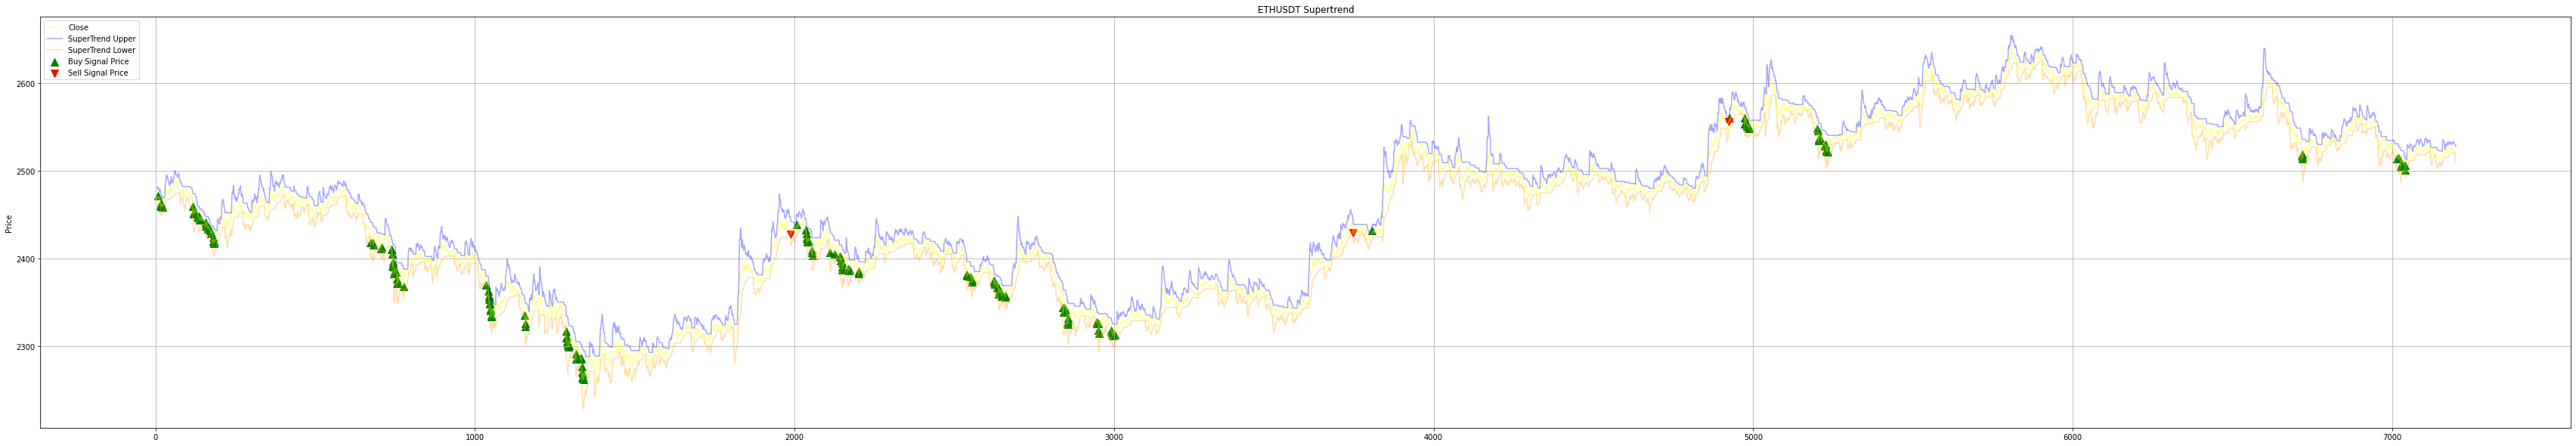

In [80]:
plt.figure(figsize=(60,10))
plt.scatter(df.index, df['Buy_Signal_Price'], label='Buy Signal Price', marker='^', color='green', s=100)
plt.scatter(df.index, df['Sell_Signal_Price'], label='Sell Signal Price', marker='v', color='red', s=100)

plt.plot(df.index, df['Close'], label='Close', color = 'yellow', alpha=0.35)
plt.plot(df.index, df['SuperTrend Upper'], label='SuperTrend Upper', color = 'blue', alpha=0.35)
plt.plot(df.index, df['SuperTrend Lower'], label='SuperTrend Lower', color = 'orange', alpha=0.35)
plt.grid(True)
plt.title(f'{ticker} Supertrend')
plt.legend(loc='upper left')
plt.ylabel('Price')